# Assignment 01: Plotting Cost Landscapes



In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA
from openqaoa.problems.problem import QUBO, MaximumCut
from openqaoa.devices import create_device

### Task 1: Build a function to generate p=1 analytical landscapes using the expectation value functions in utilies of OQ.

Plot the landscapes of four instances, e.g. w3R (weighted 3-regular graphs) with $n = 12$ qubits, with normally distributed weights, for $\mu = 0$ and $\sigma = 0.1, 1, 10, 100$.

Note: A regular graph is a graph where each vertex has the same number of neighbours (edges) 3 in this case. Weighted means that every edge is given a value (weight). 

In [2]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [3]:
# helper function to produce the cost landscape
def create_cost_landscape_std(hamiltonian, betas, gammas):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.
    
    """
    
    cost_landscape = np.zeros((betas.size, gammas.size), dtype=float)
    
    for i, beta in enumerate(betas):
        for j, gamma in enumerate(gammas):
            variational_params = [beta, gamma]
            cost_landscape[i,j] = energy_expectation_analytical(variational_params, hamiltonian)
            
           
    return cost_landscape

In [55]:
def plot_landscape(cost_landscape, betas, gammas, sigma):

    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    plt.savefig("cost_landscape_sigma={}.png".format(sigma))
    plt.show()
    
def plot_landscape_with_opt_trajectory(cost_landscape, optimization_angles, betas, gammas, sigma, optimizer):
    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
        
    # TODO not sure about the order here!
    plt.plot(optimization_angles[:, 1], optimization_angles[:, 0], '--', color='black',  )  

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    plt.savefig("cost_landscape_trajectory_sigma={}_optimizer={}.png".format(sigma, optimizer))
    plt.show()

In [30]:
def run_experiment(n: int = 12,
                   k: int = 3,
                   seed: int = 1,
                   sigma: float = 1.0,
                   mu: float = 0.0,
                   optimizer: str = "nelder-mead", 
                   betas: list = np.linspace(-np.pi/2, np.pi/2, 50) ,
                   gammas: list = np.linspace(-np.pi, np.pi, 50)):


    # Define 3wR graph and plot it
    g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
    #plot_graph(g)
    #plt.savefig("graph_sigma={}.png".format(sigma))
    #plt.clf()

    # Define te problem and translate it into a binary Qubo.
    maxcut_prob = MaximumCut(g)
    maxcut_qubo = maxcut_prob.get_qubo_problem()

    # Define Hamiltonian
    cost_hamiltonian = hamiltonian_from_graph(g)

    # Define rest of the problem and circuit
    qubit_register = range(n)
    pauli_coeffs = [1]*n
    mixer_hamiltonian = X_mixer_hamiltonian(n, pauli_coeffs)

    # Define QAOA Circuit Parameters with p=1
    circuit_params = QAOACircuitParams(cost_hamiltonian, mixer_hamiltonian, p=1)

    variate_params_std = create_qaoa_variational_params(circuit_params,'standard','ramp')
    
    cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)

    # Run QAOA experiment
    # initialize model with default configurations
    q = QAOA()

    # device
    qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
    q.set_device(qiskit_device)

    # circuit properties
    q.set_circuit_properties(p=1, param_type='standard', init_type='custom', variational_params_dict={'betas': [0.5], 'gammas': [-0.5]}, mixer_hamiltonian='x')

    # classical optimizer properties
    q.set_classical_optimizer(method=optimizer, maxiter=600, jac='finite_difference',
                              optimization_progress=True, cost_progress=True, parameter_log=True)

    q.compile(maxcut_qubo) 

    q.optimize()

    # TODO which order are the angles saved in?
    optimization_angles = np.array(q.results.intermediate['angles log'])

    optimization_energy = q.results.intermediate['intermediate cost'][-1]

    most_probable_energy = q.results.most_probable_states['bitstring_energy']


    # Solve the problem analytically
    from openqaoa.utilities import ground_state_hamiltonian
    energy, configuration = ground_state_hamiltonian(cost_hamiltonian)
    print(f"Ground State energy: {energy}, Solution: {configuration}")

    # Obtain approximation ratio
    r = np.abs(optimization_energy) / np.abs(energy)
    most_probable_r = np.abs(most_probable_energy) / np.abs(energy)

    return cost_landscape_std, optimization_angles, r, most_probable_r

In [6]:
'''
The classical optimization method. Choose from:
['imfil','bobyqa','snobfit']
['vgd', 'sgd', 'rmsprop'] 
['nelder-mead','powell','cg','bfgs','newton-cg','l-bfgs-b','cobyla'] 
'''

data = []
for sigma in [0.1, 1, 10, 100]:
    #[0.1, 1, 10, 100]
    for optimizer in ["vgd", "rmsprop", "nelder-mead", 'cobyla']:
        # vdg runs for ages, had to kill
        # ["vgd", "rmsprop", "l-bfgs-b", "nelder-mead", "cobyla"]
        print(sigma)
        print(optimizer)
        
        betas = np.linspace(-2*np.pi, 2*np.pi, 50)
        gammas = np.linspace(-2*np.pi, 2*np.pi, 50)
        
        cost_landscape, optimization_angles, r, most_probable_r = run_experiment(sigma=sigma, optimizer=optimizer, betas=betas, gammas=gammas)

        #plot_landscape(cost_landscape, betas, gammas, sigma)

        #plot_landscape_with_opt_trajectory(cost_landscape, optimization_angles, betas, gammas, sigma, optimizer)

        data.append([sigma, optimizer, r, most_probable_r])

df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'r', 'most_probable_r'])
    
df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['r'] = df['r'].astype(float)
df['most_probable_r'] = df['most_probable_r'].astype(float)

0.1
vgd
0.1
rmsprop
0.1
nelder-mead
0.1
cobyla
1
vgd
1
rmsprop
1
nelder-mead
1
cobyla
10
vgd
10
rmsprop
10
nelder-mead
10
cobyla
100
vgd
100
rmsprop
100
nelder-mead
100
cobyla


In [7]:
df

,sigma,optimizer,r,most_probable_r
0,0.1,vgd,0.501945,1.000000
1,0.1,rmsprop,0.532018,1.000000
2,0.1,nelder-mead,0.532122,1.000000
3,0.1,cobyla,0.532122,1.000000
4,1.0,vgd,0.066379,0.312392
5,1.0,rmsprop,0.532122,1.000000
6,1.0,nelder-mead,0.066379,0.312392
7,1.0,cobyla,0.532122,1.000000
8,10.0,vgd,0.030652,0.559132
9,10.0,rmsprop,0.081512,0.010074


In [20]:
df.to_csv("data.csv")

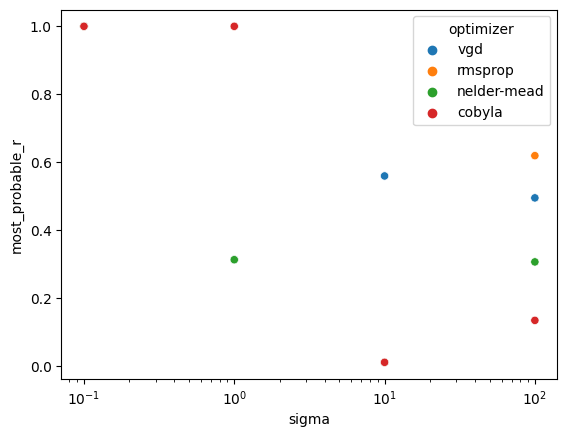

In [21]:
plt.xscale('log')
sns.scatterplot(data = df, x = 'sigma', y ='most_probable_r', hue="optimizer")
plt.savefig("Most_probable_approximation_ratio.png")

In [ ]:
plt.xscale('log')
sns.scatterplot(data = df, x = 'sigma', y ='r', hue="optimizer")
plt.savefig("Approximation_ratio.png")

Evaluate `expectation` value to construct the cost landscapes for both the parameterizations. For this purpose, we define a helper function that computes the value of each pair of angles on the grid, ($\beta_0, \gamma_0$) for StandardParams

What are the main differences between the landscapes?

### Task 2: Build script to run QAOA and solve the four instances above for a variety of optimizers (mix gradient-based and non-gradient).


Use the QAOA result object to extract the optimization trajectories and plot them on the analytical landscapes

### Task 3: Use ground_state_hamiltonian() function from OQ to obtain the exact solution to the instances

Ground State energy: -329.8374886271776, Solution: ['000000000000', '111111111111']


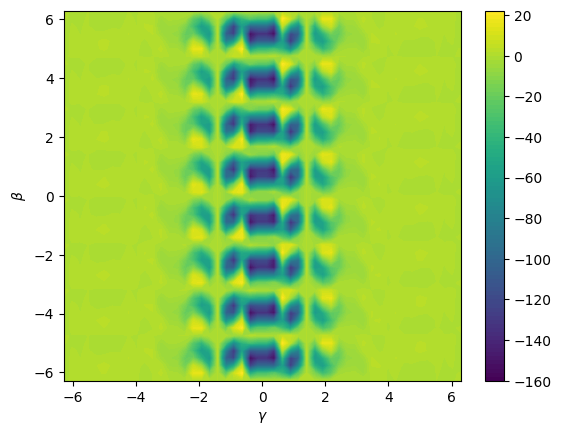

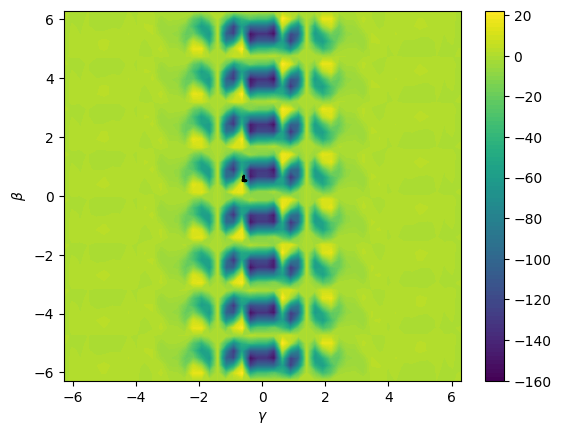

In [56]:
sigma=0.1
mu=-5.0
optimizer = "nelder-mead"

cost_landscape_FM, optimization_angles_FM, r_FM, most_probable_r_FM = run_experiment(k=11, sigma=sigma, mu=mu, optimizer=optimizer, betas=betas, gammas=gammas)

plot_landscape(cost_landscape_FM, betas, gammas, sigma)

plot_landscape_with_opt_trajectory(cost_landscape_FM, optimization_angles_FM, betas, gammas, sigma, optimizer)


In [34]:
r_FM

0.48604803563834975

Ground State energy: -32.407575402983284, Solution: ['111000011100', '000111100011']


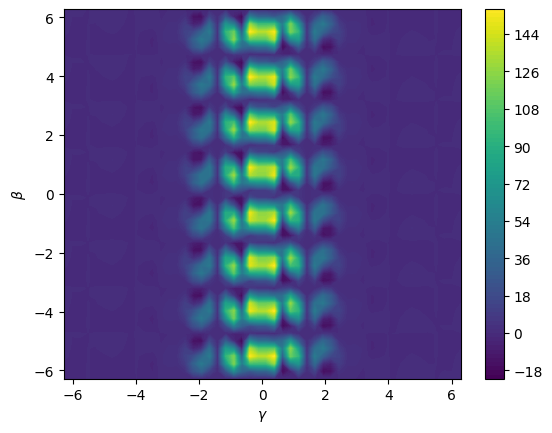

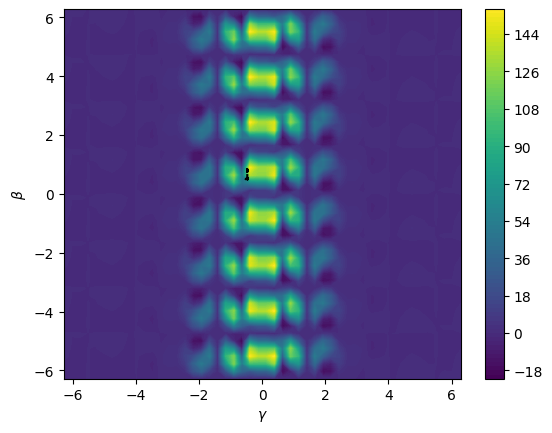

In [57]:
sigma=0.1
mu=+5.0
optimizer = "nelder-mead"

cost_landscape_AF, optimization_angles_AF, r_AF, most_probable_r_AF = run_experiment(k=11, sigma=sigma, mu=mu, optimizer=optimizer, betas=betas, gammas=gammas, seed=2)

plot_landscape(cost_landscape_AF, betas, gammas, sigma)

plot_landscape_with_opt_trajectory(cost_landscape_AF, optimization_angles_AF, betas, gammas, sigma, optimizer)


In [29]:
r_AF

0.7657401472101416

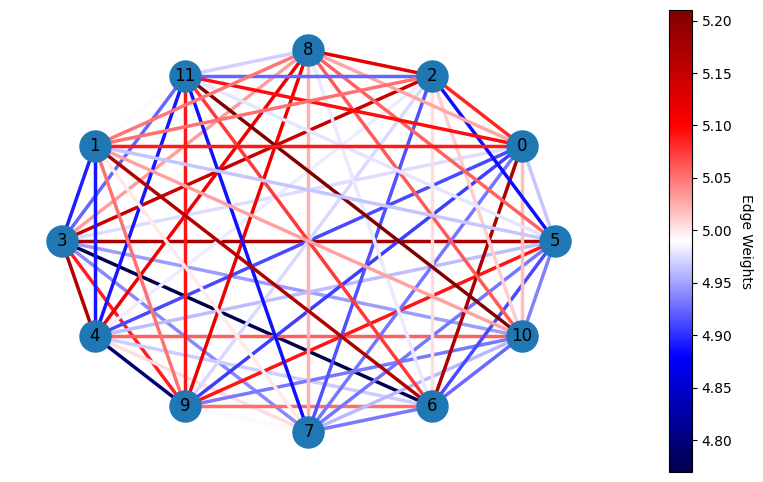

In [44]:
sigma=0.1
mu=+5.0

g = random_k_regular_graph_normal_distribution(degree=11, nodes=range(12), seed=1, weighted=True, mu=mu, sigma=sigma, biases=False)
plot_graph(g)
#plt.savefig("graph_sigma={}.png".format(sigma))
#plt.clf()

# Define Hamiltonian
cost_hamiltonian_AF = hamiltonian_from_graph(g)


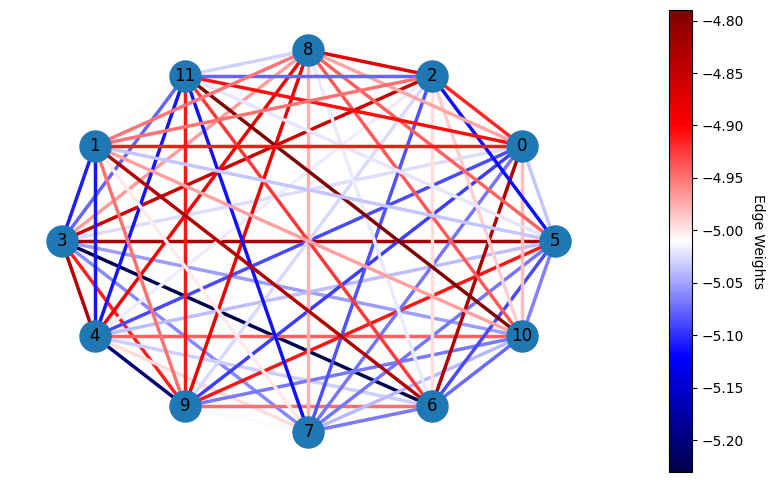

In [46]:
sigma=0.1
mu=-5.0

g = random_k_regular_graph_normal_distribution(degree=11, nodes=range(12), seed=1, weighted=True, mu=mu, sigma=sigma, biases=False)
plot_graph(g)
#plt.savefig("graph_sigma={}.png".format(sigma))
#plt.clf()

# Define Hamiltonian
cost_hamiltonian_FM = hamiltonian_from_graph(g)


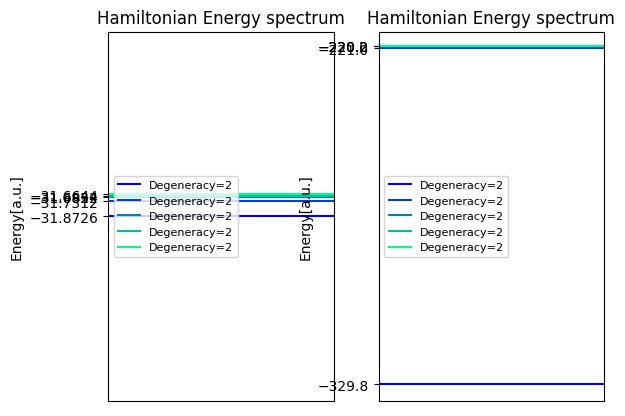

In [48]:
fig,axes = plt.subplots(1,2,sharex=True)
plot_energy_spectrum(cost_hamiltonian_AF,low_k_states=5,ax=axes[0])
plot_energy_spectrum(cost_hamiltonian_FM,low_k_states=5,ax=axes[1])
